This notebook explores plotting the netCDF fileformat that CReSIS uploaded to NSIDC:

https://nsidc.org/data/irmcr1b/versions/2

In [16]:
import netCDF4 as nc
import numpy as np
import os
import pyproj

In [7]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

In [3]:
# I downloaded sample data from a single flight
data_dir = "/Users/lindzey/Downloads/CRESIS_20181116"

In [5]:
netcdf_files = [ff for ff in os.listdir(data_dir) if ff.endswith('nc')]
netcdf_files.sort()
print(netcdf_files)

['IRMCR1B_20181116_02_001.nc', 'IRMCR1B_20181116_02_002.nc', 'IRMCR1B_20181116_02_003.nc', 'IRMCR1B_20181116_02_004.nc', 'IRMCR1B_20181116_02_005.nc', 'IRMCR1B_20181116_02_006.nc', 'IRMCR1B_20181116_02_007.nc', 'IRMCR1B_20181116_02_008.nc', 'IRMCR1B_20181116_02_009.nc', 'IRMCR1B_20181116_02_010.nc', 'IRMCR1B_20181116_02_011.nc', 'IRMCR1B_20181116_02_012.nc', 'IRMCR1B_20181116_02_013.nc', 'IRMCR1B_20181116_02_014.nc', 'IRMCR1B_20181116_02_015.nc', 'IRMCR1B_20181116_02_016.nc', 'IRMCR1B_20181116_02_017.nc', 'IRMCR1B_20181116_02_018.nc', 'IRMCR1B_20181116_02_019.nc', 'IRMCR1B_20181116_02_020.nc', 'IRMCR1B_20181116_02_021.nc', 'IRMCR1B_20181116_02_022.nc', 'IRMCR1B_20181116_02_023.nc', 'IRMCR1B_20181116_02_024.nc', 'IRMCR1B_20181116_02_025.nc', 'IRMCR1B_20181116_02_026.nc', 'IRMCR1B_20181116_02_027.nc', 'IRMCR1B_20181116_02_028.nc', 'IRMCR1B_20181116_02_029.nc', 'IRMCR1B_20181116_02_030.nc', 'IRMCR1B_20181116_02_031.nc', 'IRMCR1B_20181116_02_032.nc', 'IRMCR1B_20181116_02_033.nc', 'IRMCR1B_

In [9]:
filepath = "{}/{}".format(data_dir, netcdf_files[4])
ff = nc.Dataset(filepath, 'r') 


In [11]:
ff.ncattrs()

['location',
 'source',
 'data_version',
 'positioning',
 'title',
 'granule_id',
 'instrument',
 'institution',
 'funding',
 'investigators',
 'history',
 'max_latitude_bound',
 'min_latitude_bound',
 'max_longitude_bound',
 'min_longitude_bound',
 'min_time_bound',
 'max_time_bound',
 'rfparams',
 'digital',
 'antenna',
 'processing',
 'references']

In [ ]:
ff.variables.keys()

In [25]:
# I want to show individual surveys on an Antarctic basemap for context
# I have the simplified grounding file as part of Quantarctica 
# TODO: This dependency is ugly, and won't work on other computers. Download it separately?
gl_filepath = "/Users/lindzey/ADATA/Quantarctica/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# Example code from https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`
import matplotlib.pyplot as plt

# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)


In [49]:
def plot_cresis_netcdf_radargram(filepath, xlim=None, highlighted_traces=None):
    """
    
    Notes:
    * There are a bunch of dimension fields and variables in the netCDF file. 
      They don't seem to be documented, and they make it hard to explore the file 
      via `print(ff)` and `print(ff.variables.keys())`. Is this  
    """
    dd=nc.Dataset(filepath, 'r')
    # First dimension is fast time, 2nd dimension is slow time. We want the other way around for plotting.
    radargram = dd.variables['amplitude'][:].data.transpose()

    lat = dd.variables['lat'][:].data
    lon = dd.variables['lon'][:].data
    ps71 = pyproj.Proj("epsg:3031")
    xx, yy = ps71.transform(lon, lat)
    
    print("Radargram shape: {}, lat length: {}".format(radargram.shape, len(lat)))

    fig = plt.figure(figsize=(20, 12))
    ax1, ax2 = fig.subplots(1, 2)

    ax1.imshow(radargram, cmap='Greys', aspect='auto')
    ax1.set_title("Radargram")
        
    ax2.plot(xx, yy, 'k.', markersize=2)
    ax2.plot(gl_xx, gl_yy, '.', color='lightgrey', markersize=0.5)
    map_buffer = 25000
    map_xlim = (min(xx) - map_buffer, max(xx) + map_buffer)
    map_ylim = (min(yy) - map_buffer, max(yy) + map_buffer)
    ax2.set_title("Segment track")
    ax2.set_xlabel("Easting (m)")
    ax2.set_ylabel("Northing (m)")
    ax2.axis('equal')
    ax2.set_xlim(map_xlim)
    ax2.set_ylim(map_ylim)
    
    if xlim is not None:
        ax1.set_xlim(xlim)
        ax2.plot(xx[xlim[0]:xlim[1]], yy[xlim[0]:xlim[1]], 'r.', markersize=4)
    
    if highlighted_traces is not None:
        num_samples, _ = radargram.shape
        ax1.vlines(highlighted_traces, 0, radargram.shape[0])
        ax2.plot(xx[highlighted_traces], yy[highlighted_traces], 'co', fillstyle='none', markersize=10)

Radargram shape: (3154, 3335), lat length: 3335


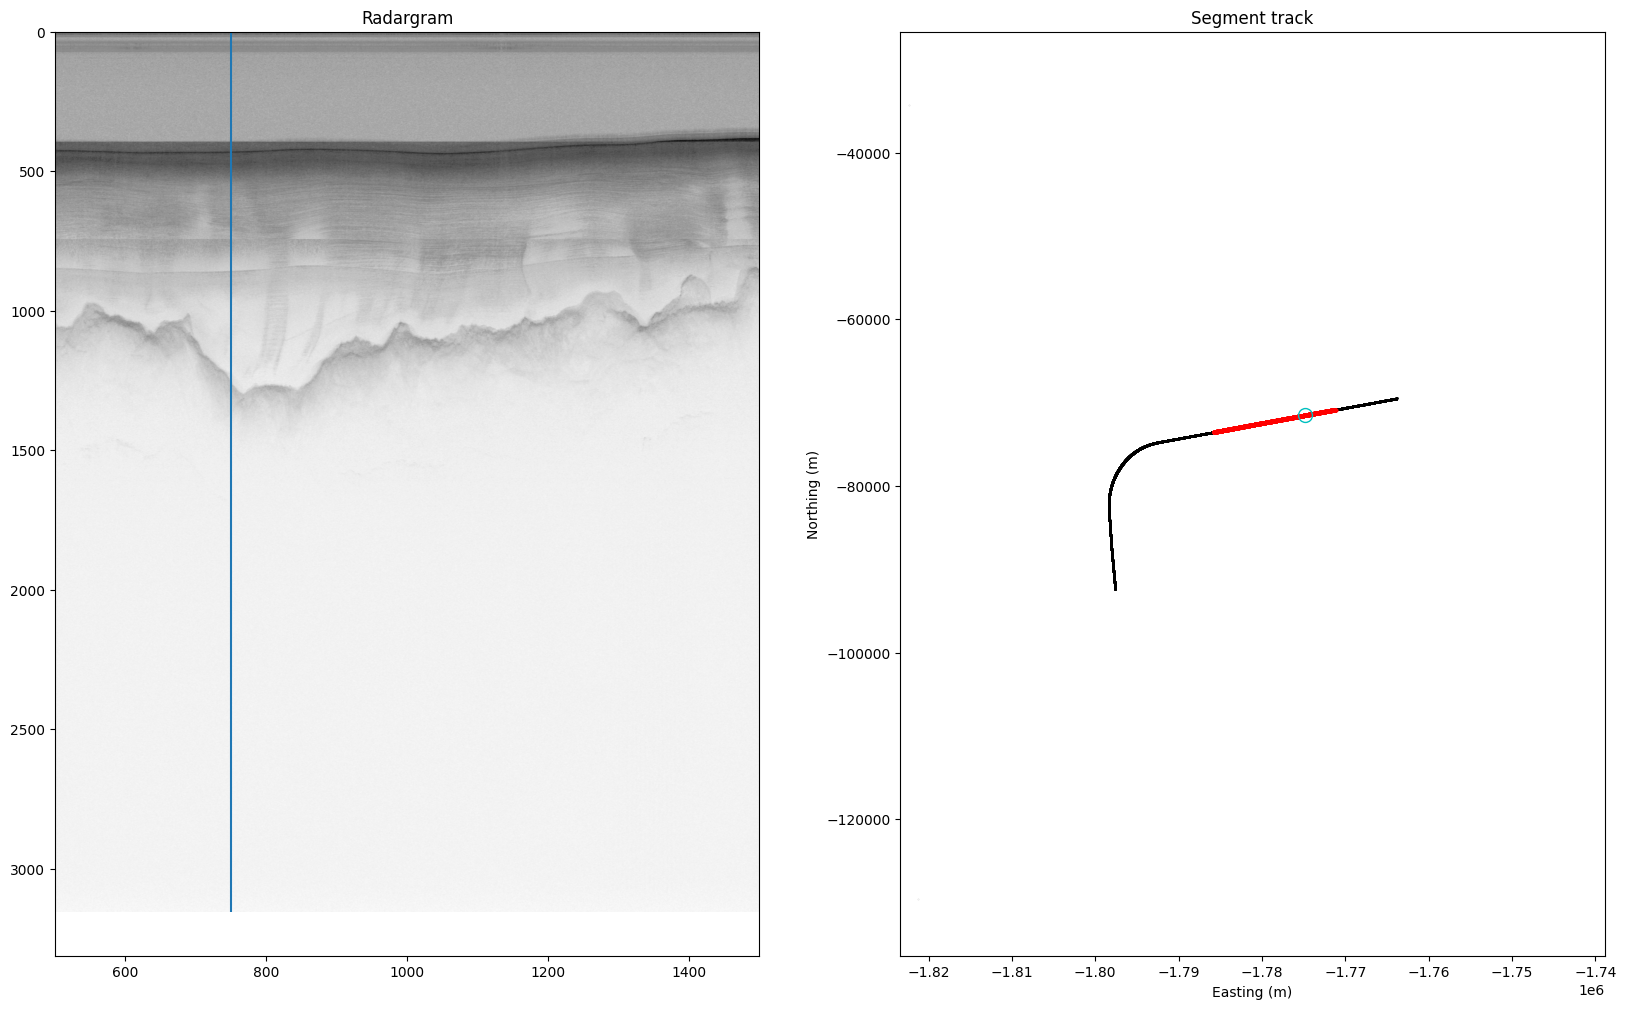

In [50]:
plot_cresis_netcdf_radargram(filepath, (500, 1500), (750))